# Importy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter

In [2]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install sktime

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install tslearn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


# Načtení a příprava dat

In [7]:
df =pd.read_csv("./smaller-labeled-dataset.csv",  header=None) # nrows=100,
#df = df.reset_index()

In [8]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket

In [9]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler, TimeSeriesScalerMinMax

In [10]:
p = df.values

In [11]:
(p.shape[1] - 22 - 2) / 12

501.0

In [12]:
nof_params = 22
nof_vars = 12
nof_samples = int((p.shape[1] - nof_params - 1)/ nof_vars)
pre_ts = p[:,nof_params:nof_params+nof_samples*nof_vars]
pre_ts /= pre_ts.max(axis=1)[:,None]
ts = np.reshape(pre_ts, (p.shape[0], nof_samples, nof_vars))[:,:,[5, 10]]

In [13]:
ts.shape

(70, 501, 2)

# Predikce

In [14]:
#for nof_clusters, gamma, max_iter in [(n, g, m) for n in [2,3,4,5,6] for g in range(0.1,1.0, 0.1) for m in [10, 20, 30, 40]]:
#  model = TimeSeriesKMeans(n_clusters=nof_clusters, metric="softdtw",
#                           metric_params={"gamma": gama},
#                           max_iter=max_iter, random_state=1234)
#  y_pred = model.fit_predict(X_train)
#  ... spocitas accuracy (znas jaky by to mal byt typ protoze to mas v tom pridanem sloupecku ;) a ulozis pro analyzu ...

In [41]:
#tvorba souboru s hlavickou pro ukladani vysledku
f = open('twenty-inits-69.csv', 'a')
f.write('max_iter, accuracy')
f.close()

In [21]:
with open('dtw.csv', 'a') as f:
    X_train = TimeSeriesResampler(sz=100).fit_transform(ts)
    sz = X_train.shape[1]
    
    #print(np.any(np.isnan(X_train)))
    #print(np.any(np.isfinite(X_train)))

    nof_clusters = 7
    
    #nastaveni algoritmu klasterizace
    for gamma, max_iter in [(g, m) for g in np.arange(0.1, 1.0, 0.1) for m in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]:
        model = TimeSeriesKMeans(n_clusters=nof_clusters, metric="softdtw",
                               metric_params={"gamma": gamma},
                               max_iter=max_iter, random_state=69,
                               n_jobs=-1, n_init=5)
        model.fit(X_train)
        y_pred = model.predict(X_train)

        #vypocet accuracy a mapovani
        classes = ['alergie', 'chronicka-nemoc', 'chronicky-zanet', 'neplausibilni', 'smrt-er', 'smrt-pato', 'vyleceno']
        cluster_sizes = []
        cnt = 0
        clusters_by_size = []
        clusters = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
        compar_types = []
        y_true = []
        y_true_clusters = []

        #tvorba pole nami urcenych labelu - "spravna odpoved"
        for m in range(len(p)):
            y_true.append(p[m][-1])
        
        #ziskani prubehu prirazenych do jednotlivych klastru a velikosti klastru
        for i in range(nof_clusters):
            for j, idx in enumerate(np.where(y_pred == i)[0]): 
                compar_types.append(p[idx][-1])
                cnt += 1
            cluster_sizes.append(cnt)
            y_true_clusters.append(compar_types)
            cnt = 0
            compar_types = []
        sorted_l = sorted(cluster_sizes, reverse=True) #pomocne pole k razeni klastru podle velikosti

        #razeni klastru podle velikosti
        for k in sorted_l:
            cluster = cluster_sizes.index(k)
            if (cluster in clusters_by_size):
                while(cluster in clusters_by_size):
                    cluster = cluster_sizes.index(k, cluster + 1)
            clusters_by_size.append(cluster)

        #prirazeni labelu podle majoritniho prvku - tam, kde to jde a s nicim nekoliduje
        for i in range(len(clusters_by_size)):
            c = Counter(y_true_clusters[clusters_by_size[i]])
            c_dom = c.most_common(1)[0][0]
            if(c_dom not in clusters):
                clusters[clusters_by_size[i]] = c_dom
                classes.remove(c_dom)
                clusters_by_size[i] = -1

        #priradeni ostatnich labelu - podle velikosti
        for i in range(len(clusters_by_size)):
            if clusters_by_size[i] != -1:
                clusters[clusters_by_size[i]] = classes[0]
                del classes[0]

        #transformace predpovezenych klastru z cisel do labelu dle vznikleho mapovani        
        y_pred_class = []
        for i in y_pred:
            y_pred_class.append(clusters[i])

        #vypocet accuracy a zaznamenani vysledku
        acc_score = accuracy_score(y_true, y_pred_class)
        print(acc_score)
        f.write('\n')
        f.write(str(gamma) + ', ' + str(max_iter) + ', ' + str(acc_score))
        f.flush()
    
#  ... spocitas accuracy (znas jaky by to mal byt typ protoze to mas v tom pridanem sloupecku ;) a ulozis pro analyzu ...

0.4
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.37142857142857144
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5142857142857142
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.5857142857142857
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.4142857142857143
0.5285714285714286
0.5285714285714286
0.528571428571428

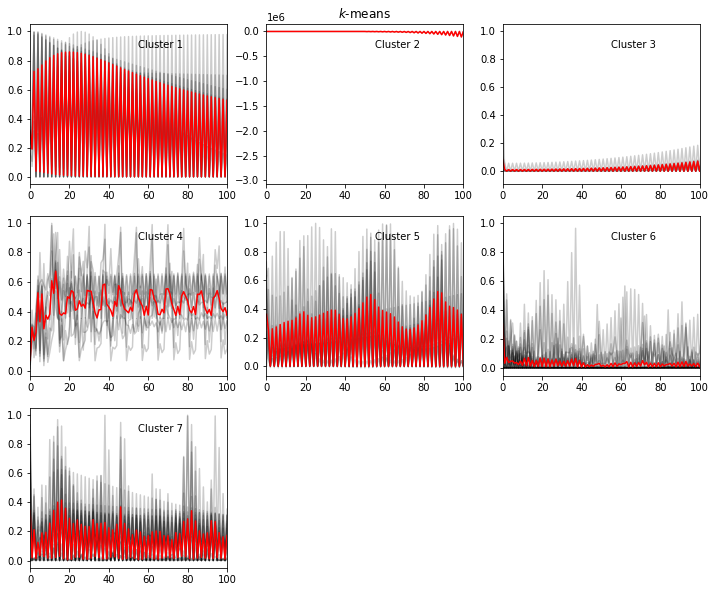

In [43]:
km = model
plt.figure(figsize=(12,10))
for yi in range(nof_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("$k$-means")

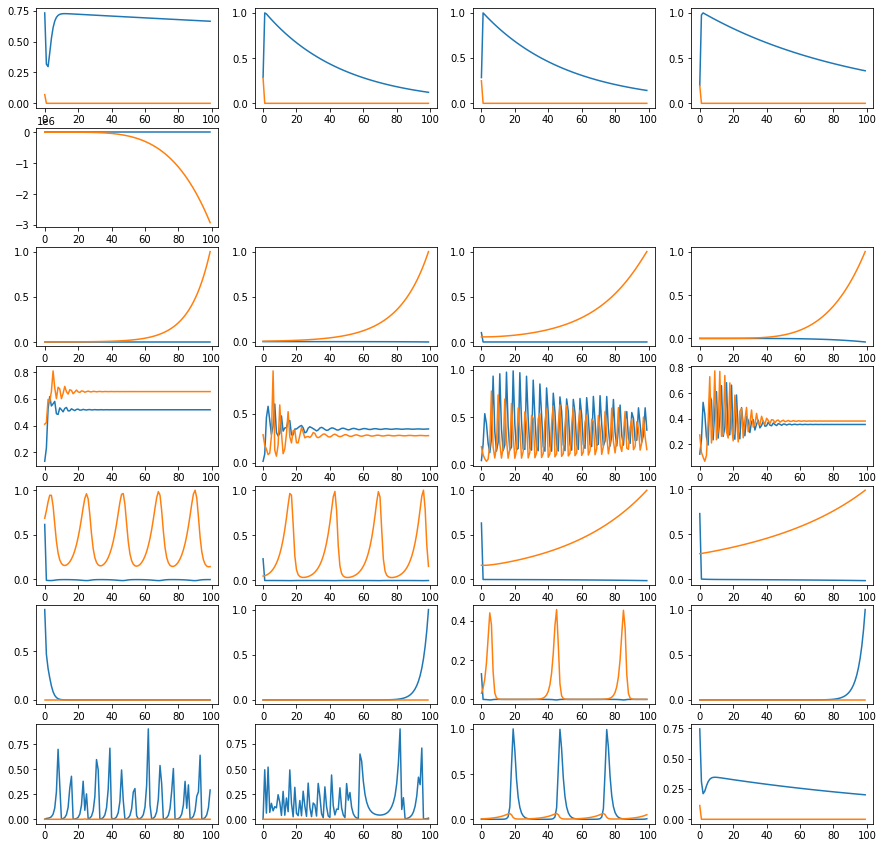

In [44]:
n = nof_clusters
nn = 4 #tolikrat probehne vnitrni cyklus

plt.figure(figsize=(15,15))

for i in range(n):
    sims_in_cluster = []
    for j, idx in enumerate(np.where(y_pred == i)[0]): 
        #prochazi veci v tride
        #np.where vyplivne indexy kde plati podminka
        sims_in_cluster.append(idx)
        
    for k in range(nn):
        if len(sims_in_cluster) == 0:
            break
        else:
            chosen = random.choice(sims_in_cluster)
            plt.subplot(n, nn, nn*i+k+1)
            plt.plot(X_train[chosen,:,:])
            sims_in_cluster.remove(chosen)


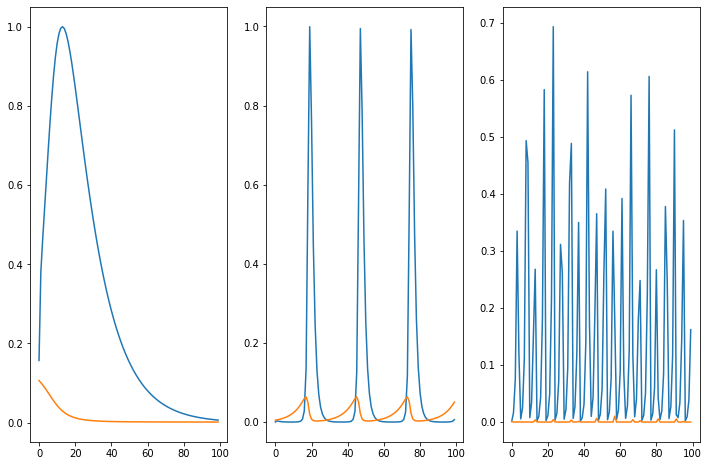

In [45]:
plt.figure(figsize=(12,8))
plt.subplot(1, 3, 1)
plt.plot(X_train[0,:,:])
plt.subplot(1, 3, 2)
plt.plot(X_train[1,:,:])
plt.subplot(1, 3, 3)
plt.plot(X_train[2,:,:])


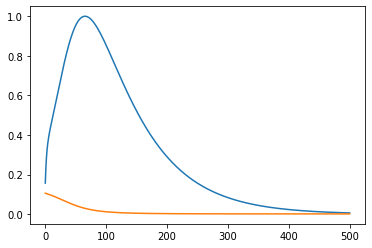

In [46]:
plt.plot(ts[0,:,:])

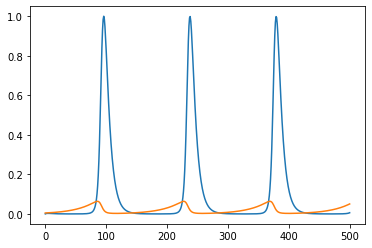

In [47]:
plt.plot(ts[1,:,:])

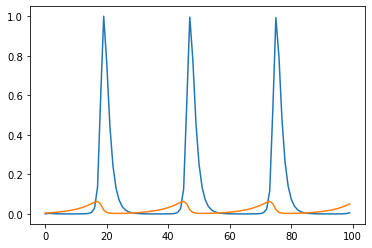

In [48]:
plt.plot(X_train[1,:,:])